# Loading and Setup

In [645]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn import metrics


In [646]:
maven_df = pd.read_pickle('Data/maven_toys.pkl')

# Assessment

In [647]:
maven_df.tail()

,Store_Location,Store_Name,Product_Category,Product_Price,Product_Cost,Date,Units,Sale_Payment_Type,Product_Name,Customer_Satisfaction,Store_City,Sale_ID,Store_ID,Product_ID,Store_Open_Date,Customer_Reference
829257,Residential,Maven Toys Puebla 3,Art & Crafts,$2.99,$1.99,2018-05-15,3,credit,PlayDoh Can,9.0,Puebla,625020,44,25,2014-12-27,Social Media Ad
829258,Residential,Maven Toys Puebla 3,Games,$6.99,$3.99,2017-07-17,1,credit,Deck Of Cards,9.0,Puebla,217169,44,8,2014-12-27,Word of Mouth
829259,Residential,Maven Toys Puebla 3,Art & Crafts,$4.99,$3.99,2017-07-08,1,credit,PlayDoh Toolkit,10.0,Puebla,206813,44,27,2014-12-27,Social Media Ad
829260,Residential,Maven Toys Puebla 3,Sports & Outdoors,$19.99,$14.99,2018-04-02,1,cash,Nerf Gun,9.0,Puebla,556796,44,24,2014-12-27,Social Media Ad
829261,Residential,Maven Toys Puebla 3,Sports & Outdoors,$15.99,$11.99,2017-02-03,1,credit,Dart Gun,8.0,Puebla,31396,44,7,2014-12-27,TV Ad


In [648]:
# Check the shape of the maven_dfFrame
maven_df.nunique()

Store_Location                4
Store_Name                   50
Product_Category              5
Product_Price                18
Product_Cost                 16
Date                        638
Units                        27
Sale_Payment_Type             2
Product_Name                 35
Customer_Satisfaction        10
Store_City                   29
Sale_ID                  829262
Store_ID                     50
Product_ID                   35
Store_Open_Date              50
Customer_Reference            5
dtype: int64

In [649]:
# Check the data types and missing values
maven_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829262 entries, 0 to 829261
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Store_Location         829262 non-null  object 
 1   Store_Name             829262 non-null  object 
 2   Product_Category       829262 non-null  object 
 3   Product_Price          829262 non-null  object 
 4   Product_Cost           829262 non-null  object 
 5   Date                   829262 non-null  object 
 6   Units                  829262 non-null  int64  
 7   Sale_Payment_Type      829262 non-null  object 
 8   Product_Name           829262 non-null  object 
 9   Customer_Satisfaction  789954 non-null  float64
 10  Store_City             829262 non-null  object 
 11  Sale_ID                829262 non-null  int64  
 12  Store_ID               829262 non-null  int64  
 13  Product_ID             829262 non-null  int64  
 14  Store_Open_Date        829262 non-nu

In [650]:
# Fill missing values in 'Customer_Satisfaction' with the median
# maven_df['Customer_Satisfaction'].fillna(maven_df['Customer_Satisfaction'].median(), inplace=True)

# Check if there are any missing values left
maven_df.isnull().sum()

Store_Location               0
Store_Name                   0
Product_Category             0
Product_Price                0
Product_Cost                 0
Date                         0
Units                        0
Sale_Payment_Type            0
Product_Name                 0
Customer_Satisfaction    39308
Store_City                   0
Sale_ID                      0
Store_ID                     0
Product_ID                   0
Store_Open_Date              0
Customer_Reference           0
dtype: int64

In [651]:
# Checking for duplicates
maven_df.duplicated().sum()



0

# Cleaning

In [652]:
# Convert 'Date' and 'Store_Open_Date' to datetime type
maven_df['Date'] = pd.to_datetime(maven_df['Date'])
maven_df['Store_Open_Date'] = pd.to_datetime(maven_df['Store_Open_Date'])
maven_df['Product_Price'] = maven_df['Product_Price'].str.replace('$', '').astype(float)
maven_df['Product_Cost'] = maven_df['Product_Cost'].str.replace('$', '').astype(float)
maven_df['Product_Category'] = maven_df['Product_Category'].astype('category')
maven_df['Store_Location'] = maven_df['Store_Location'].astype('category')
maven_df['Customer_Reference'] = maven_df['Customer_Reference'].astype('category')
maven_df = maven_df.drop(columns=['Sale_ID', 'Product_ID', 'Store_ID'])
maven_df['Data_Month'] = maven_df['Date'].dt.month
maven_df['Store_Open_Month'] = maven_df['Store_Open_Date'].dt.month

# Extract the month and year from the 'Date' column
maven_df['YearMonth'] = maven_df['Date'].dt.to_period('M')

# Check the maven_df types again to confirm
maven_df.dtypes

Store_Location                 category
Store_Name                       object
Product_Category               category
Product_Price                   float64
Product_Cost                    float64
Date                     datetime64[ns]
Units                             int64
Sale_Payment_Type                object
Product_Name                     object
Customer_Satisfaction           float64
Store_City                       object
Store_Open_Date          datetime64[ns]
Customer_Reference             category
Data_Month                        int32
Store_Open_Month                  int32
YearMonth                     period[M]
dtype: object

## Feature Engineering

In [653]:

maven_df['Price_Bins'] = pd.cut(maven_df['Product_Price'], bins=5, labels=['medium-low', 'low', 'medium', 'high', 'medium-high'])
maven_df['Product_profit'] = maven_df['Units'] * (maven_df['Product_Price'] - maven_df['Product_Cost'])

maven_df['Growth_Potential_1'] = maven_df.Product_profit * maven_df.Customer_Satisfaction
maven_df['Profit_Ratio'] = maven_df.Product_Price / maven_df.Product_Cost 
maven_df['Growth_Potential_2'] = maven_df.Profit_Ratio * maven_df.Customer_Satisfaction

maven_df.head()




,Store_Location,Store_Name,Product_Category,Product_Price,Product_Cost,Date,Units,Sale_Payment_Type,Product_Name,Customer_Satisfaction,...,Store_Open_Date,Customer_Reference,Data_Month,Store_Open_Month,YearMonth,Price_Bins,Product_profit,Growth_Potential_1,Profit_Ratio,Growth_Potential_2
0,Airport,Maven Toys Ciudad de Mexico 2,Toys,39.99,34.99,2017-05-31,1,cash,Lego Bricks,9.0,...,2012-05-04,Social Media Ad,5,5,2017-05,medium-high,5.0,45.0,1.142898,10.286082
1,Airport,Maven Toys Ciudad de Mexico 2,Electronics,25.99,20.99,2018-06-04,1,cash,Toy Robot,7.0,...,2012-05-04,Word of Mouth,6,5,2018-06,high,5.0,35.0,1.238209,8.667461
2,Airport,Maven Toys Ciudad de Mexico 2,Games,10.99,5.99,2017-06-05,1,credit,Glass Marbles,10.0,...,2012-05-04,Social Media Ad,6,5,2017-06,low,5.0,50.0,1.834725,18.347245
3,Airport,Maven Toys Ciudad de Mexico 2,Electronics,20.99,14.99,2018-03-09,1,cash,Gamer Headphones,9.0,...,2012-05-04,Word of Mouth,3,5,2018-03,medium,6.0,54.0,1.400267,12.602402
4,Airport,Maven Toys Ciudad de Mexico 2,Games,6.99,3.99,2018-02-22,1,credit,Deck Of Cards,8.0,...,2012-05-04,Social Media Ad,2,5,2018-02,medium-low,3.0,24.0,1.751880,14.015038


# EDA

<AxesSubplot: xlabel='Product_Name'>

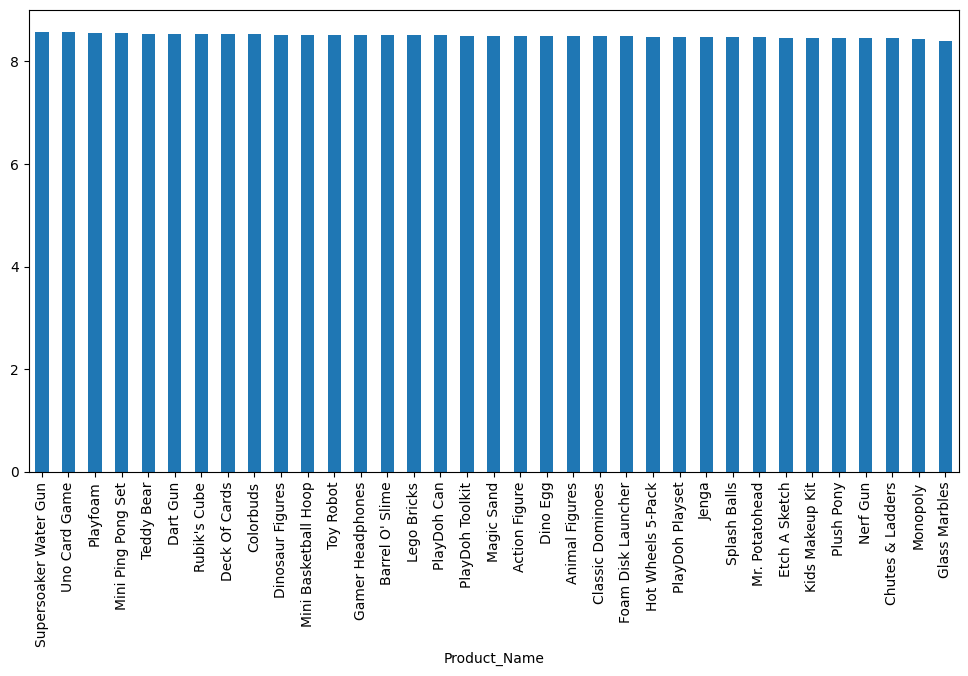

In [672]:
# Find the top 10 products with the highest customer satisfaction
maven_df.groupby('Product_Name')['Customer_Satisfaction'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))


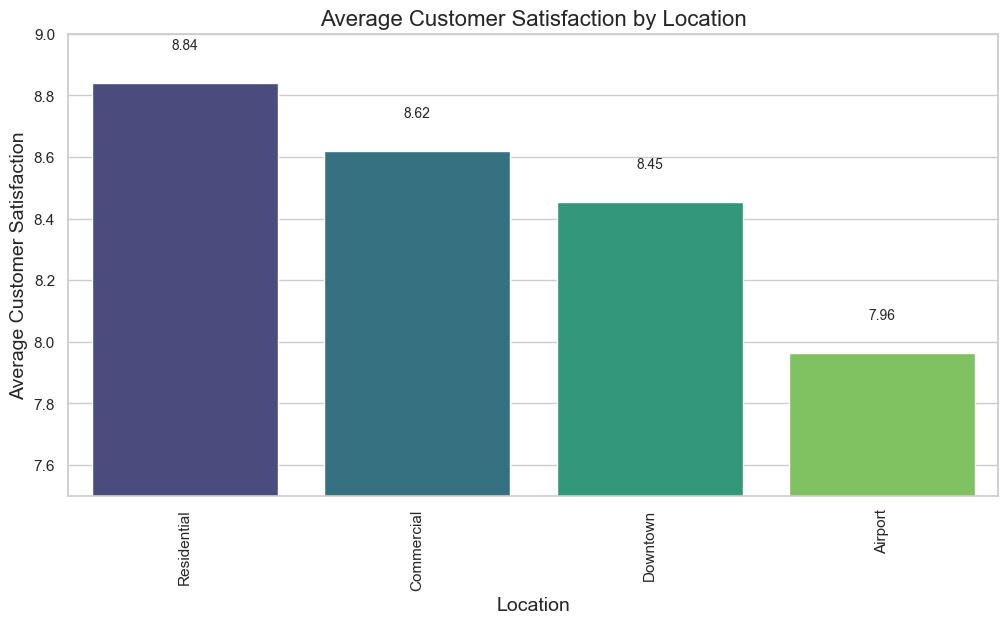

In [696]:
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 6))
satisfaction_by_city = maven_df.groupby('Store_Location')['Customer_Satisfaction'].mean().sort_values(ascending=False)
sns.barplot(x=satisfaction_by_city.index, y=satisfaction_by_city.values, palette="viridis", order=satisfaction_by_city.index)

# Add labels and title
plt.xlabel('Location', fontsize=14)
plt.ylabel('Average Customer Satisfaction', fontsize=14)
plt.title('Average Customer Satisfaction by Location', fontsize=16)
plt.ylim(7.5, 9)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Annotate bars with their values
for i, v in enumerate(satisfaction_by_city.values):
    plt.text(i, v + 0.1, round(v, 2), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()


Store_Location
Residential    8.840400
Commercial     8.619994
Downtown       8.452857
Airport        7.962551
Name: Customer_Satisfaction, dtype: float64

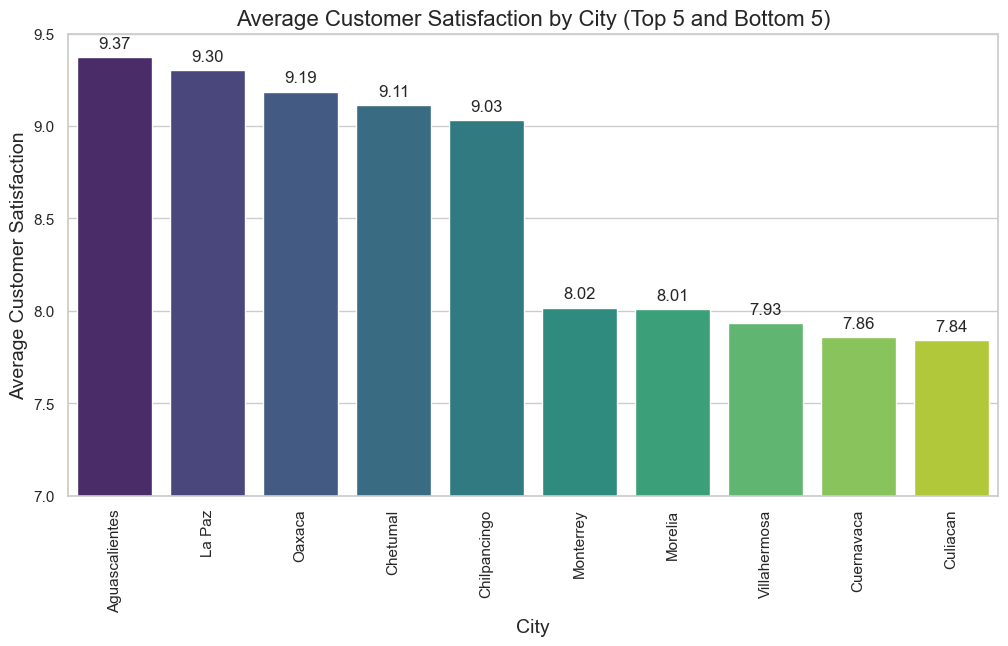

In [697]:
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(12, 6))

# Select top 5 and bottom 5 cities by customer satisfaction
top_5_cities = maven_df.groupby('Store_City')['Customer_Satisfaction'].mean().sort_values(ascending=False).head(5)
bottom_5_cities = maven_df.groupby('Store_City')['Customer_Satisfaction'].mean().sort_values(ascending=False).tail(5)

# Concatenate top 5 and bottom 5 cities
satisfaction_by_city = pd.concat([top_5_cities, bottom_5_cities])

# Create bar plot
barplot = sns.barplot(x=satisfaction_by_city.index, y=satisfaction_by_city.values, palette="viridis")

# Add labels and title
plt.xlabel('City', fontsize=14)
plt.ylabel('Average Customer Satisfaction', fontsize=14)
plt.title('Average Customer Satisfaction by City (Top 5 and Bottom 5)', fontsize=16)
plt.ylim(7, 9.5)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Annotate bars with their values
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

# Show the plot
plt.show()


In [678]:
maven_df.groupby('Price_Bins')['Customer_Satisfaction'].mean().sort_values(ascending=False).head(10)



Price_Bins
high           8.509666
medium-low     8.507069
medium-high    8.506177
low            8.504295
medium         8.488730
Name: Customer_Satisfaction, dtype: float64

In [680]:
# Compare the sales of the stores in Guadalajara to the sales of stores in other areas
maven_df.groupby('Product_Name')['Customer_Satisfaction'].describe().sort_values(by='mean',ascending=False).head(10)



,count,mean,std,min,25%,50%,75%,max
Product_Name,,,,,,,,
Supersoaker Water Gun,5792.0,8.582010,1.975897,0.0,8.0,9.0,10.0,10.0
Uno Card Game,2475.0,8.581414,2.007096,0.0,8.0,9.0,10.0,10.0
Playfoam,2701.0,8.560533,2.113392,0.0,8.0,9.0,10.0,10.0
Mini Ping Pong Set,23675.0,8.557761,1.986243,0.0,8.0,9.0,10.0,10.0
Teddy Bear,5709.0,8.543177,2.117295,0.0,8.0,9.0,10.0,10.0
Dart Gun,24769.0,8.535710,2.105585,0.0,8.0,9.0,10.0,10.0
Rubik's Cube,36105.0,8.527462,2.082613,0.0,8.0,9.0,10.0,10.0
Deck Of Cards,65800.0,8.526839,2.120823,0.0,8.0,9.0,10.0,10.0
Colorbuds,70035.0,8.526080,2.131380,0.0,8.0,9.0,10.0,10.0


In [660]:
maven_df.groupby('Customer_Reference')['Customer_Satisfaction'].describe().sort_values(by='mean',ascending=False).head(10)


,count,mean,std,min,25%,50%,75%,max
Customer_Reference,,,,,,,,
No Answer,120741.0,8.508684,2.122039,0.0,8.0,9.0,10.0,10.0
TV Ad,110671.0,8.505941,2.121893,0.0,8.0,9.0,10.0,10.0
Word of Mouth,216421.0,8.501744,2.122275,0.0,8.0,9.0,10.0,10.0
Social Media Ad,298240.0,8.501267,2.133882,0.0,8.0,9.0,10.0,10.0
Billboard Ad,43881.0,8.501196,2.123501,0.0,8.0,9.0,10.0,10.0


In [661]:
# # Compare the sales of the individual stores in Guadalajara
maven_df.groupby('Product_Name')['Customer_Satisfaction'].describe().sort_values(by='mean',ascending=False).head(10)



,count,mean,std,min,25%,50%,75%,max
Product_Name,,,,,,,,
Supersoaker Water Gun,5792.0,8.582010,1.975897,0.0,8.0,9.0,10.0,10.0
Uno Card Game,2475.0,8.581414,2.007096,0.0,8.0,9.0,10.0,10.0
Playfoam,2701.0,8.560533,2.113392,0.0,8.0,9.0,10.0,10.0
Mini Ping Pong Set,23675.0,8.557761,1.986243,0.0,8.0,9.0,10.0,10.0
Teddy Bear,5709.0,8.543177,2.117295,0.0,8.0,9.0,10.0,10.0
Dart Gun,24769.0,8.535710,2.105585,0.0,8.0,9.0,10.0,10.0
Rubik's Cube,36105.0,8.527462,2.082613,0.0,8.0,9.0,10.0,10.0
Deck Of Cards,65800.0,8.526839,2.120823,0.0,8.0,9.0,10.0,10.0
Colorbuds,70035.0,8.526080,2.131380,0.0,8.0,9.0,10.0,10.0


In [662]:
maven_df.groupby('Sale_Payment_Type')['Customer_Satisfaction'].mean().sort_values(ascending=False)

Sale_Payment_Type
credit    8.523458
cash      8.459726
Name: Customer_Satisfaction, dtype: float64

<AxesSubplot: >

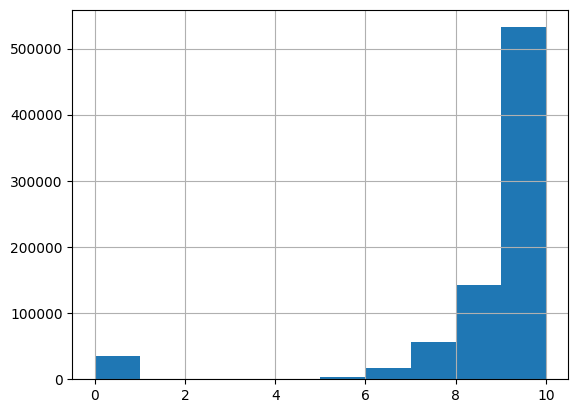

In [663]:
# Calculate the average customer satisfaction
maven_df['Customer_Satisfaction'].hist(bins=10)


In [664]:
topProduct = maven_df.groupby('Product_Name')[['Product_profit', 'Units']].sum().sort_values(by='Product_profit', ascending=False).head(10)
topProduct = topProduct.reset_index()

#Generating the labels which will show the sales value in K figure
topProduct['Total_Profit_M'] = ['$ '+str(round(int(v)/1000000,2))+' M' for v in topProduct.Product_profit]

topProduct


,Product_Name,Product_profit,Units,Total_Profit_M
0,Colorbuds,834944.0,104368,$ 0.83 M
1,Action Figure,347748.0,57958,$ 0.35 M
2,Lego Bricks,298685.0,59737,$ 0.3 M
3,Deck Of Cards,252102.0,84034,$ 0.25 M
4,Glass Marbles,187590.0,37518,$ 0.19 M
5,Barrel O' Slime,183326.0,91663,$ 0.18 M
6,Kids Makeup Kit,146598.0,24433,$ 0.15 M
7,Nerf Gun,132715.0,26543,$ 0.13 M
8,Dart Gun,126352.0,31588,$ 0.13 M
9,Etch A Sketch,121680.0,12168,$ 0.12 M


In [665]:
topCategories = maven_df.groupby('Product_Category')[['Product_profit', 'Units']].agg(['mean', 'sum'])
topCategories = topCategories.reset_index()

#Generating the labels which will show the sales value in K figure
# topProduct['Total_Profit_M'] = ['$ '+str(round(int(v)/1000000,2))+' M' for v in topProduct.Product_profit]

topProduct


,Product_Name,Product_profit,Units,Total_Profit_M
0,Colorbuds,834944.0,104368,$ 0.83 M
1,Action Figure,347748.0,57958,$ 0.35 M
2,Lego Bricks,298685.0,59737,$ 0.3 M
3,Deck Of Cards,252102.0,84034,$ 0.25 M
4,Glass Marbles,187590.0,37518,$ 0.19 M
5,Barrel O' Slime,183326.0,91663,$ 0.18 M
6,Kids Makeup Kit,146598.0,24433,$ 0.15 M
7,Nerf Gun,132715.0,26543,$ 0.13 M
8,Dart Gun,126352.0,31588,$ 0.13 M
9,Etch A Sketch,121680.0,12168,$ 0.12 M


In [666]:
# Calculate the monthly sales for each product category
category_sales = maven_df.groupby(['YearMonth', 'Product_Category'])['Customer_Satisfaction'].mean().unstack().rolling(3).mean().dropna()
category_sales


Product_Category,Art & Crafts,Electronics,Games,Sports & Outdoors,Toys
YearMonth,,,,,
2017-03,8.486985,8.504490,8.530221,8.548300,8.529451
2017-04,8.510726,8.531632,8.519915,8.535897,8.520529
2017-05,8.487049,8.528280,8.513113,8.538523,8.513276
2017-06,8.486088,8.515242,8.509781,8.516546,8.512734
2017-07,8.470939,8.501937,8.523041,8.490184,8.522655
2017-08,8.508608,8.497985,8.521719,8.479585,8.524483
2017-09,8.525720,8.506903,8.521455,8.466402,8.522072
2017-10,8.503583,8.524166,8.512512,8.493784,8.513225
2017-11,8.494785,8.560276,8.494853,8.508436,8.501946


# Model Preparation, Fitting, and Testing

In [667]:
# dummy_df = pd.get_dummies(maven_df, 
#         columns=['Store_Location', 'Product_Category', 'Sale_Payment_Type', 'Store_City', 'Customer_Reference'])

# maven_df = pd.concat([maven_df, dummy_df], axis=1)

# maven_df.head()
# X = maven_df.drop(columns=['Store_Location', 'YearMonth', 'Price_Bins', 'Product_Category', 'Sale_Payment_Type', 'Store_City', 'Customer_Reference', 'Customer_Satisfaction', 'Store_Name', 'Product_Name', 'Date', 'Store_Open_Date'], axis=1)
# X
# y = maven_df['Customer_Satisfaction'].copy()

# corr = X.corr()

# mask = np.triu(X.corr())

# plt.figure(figsize=(20,20))
# sns.heatmap(X.corr().round(2), annot=True, vmax=1, vmin=-1, cmap='coolwarm', mask=mask, center=0)

# plt.show()
# X_withconstant = sm.add_constant(X)

# lin_reg = sm.OLS(y,X_withconstant)

# lin_reg_fitted = lin_reg.fit()

# lin_reg_fitted.summary()


In [668]:
# maven_df['Data_Month'] = maven_df['Date'].dt.month
# maven_df['Store_Open_Month'] = maven_df['Store_Open_Date'].dt.month
# X = maven_df.drop(['Customer_Satisfaction', 'Store_Name', 'Product_Name', 'Date', 'Store_Open_Date'], axis=1)
# y = maven_df['Customer_Satisfaction'].copy()

# corr_df = X.corr()

# corr_df
# mask = np.triu(corr_df)

# plt.figure(figsize=(20,20))
# sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, cmap='coolwarm', mask=mask, center=0)

# plt.show()
# threshold = 0.7

# strong_corr_array = np.where(abs(corr_df) > threshold)

# strong_corr_pairs = pd.DataFrame({'Variable 1': corr_df.index[strong_corr_array[0]],
#                             'Variable 2': corr_df.columns[strong_corr_array[1]],
#                             'Correlation Coefficient': corr_df.values[strong_corr_array]})

# # remove the pairs of same variable
# strong_corr_pairs = strong_corr_pairs.loc[strong_corr_pairs['Correlation Coefficient'] != 1]

# strong_corr_pairs

# Model Evaluation

# Final Insights

### How are we doing with customer satisfaction?

EDA: 
What areas have the highest customer satisfaction?  
Store Locations  
  

City Locations

Model:
Linear Regression on Customer Satisfaction  
More Exploratory Data Analysis on Customer Satisfaction

### What does the data say about how we can grow our business?
Expansion: 
High Customer Satisfaction, Profit, and Amount of Units Sold

Time series on satisfaction, profit, units sold?

Independent
Products, Locations, Which Month, Store Open Date ---- Store Duration

Customer Reference

Target Category 
Profit and Satisfactory

1. Sum profit by Location and then Divide by Number of Days Open - Profitability Metric
   1. Store Location, Store City 
   2. Use this to evaluate the profitability of each store location
2. Products 
   1. Most profitable categories, Most profitable products
3. Which month is the most profitable
   1. Which month is the most profitable for each location







In [669]:
maven_df

,Store_Location,Store_Name,Product_Category,Product_Price,Product_Cost,Date,Units,Sale_Payment_Type,Product_Name,Customer_Satisfaction,...,Store_Open_Date,Customer_Reference,Data_Month,Store_Open_Month,YearMonth,Price_Bins,Product_profit,Growth_Potential_1,Profit_Ratio,Growth_Potential_2
0,Airport,Maven Toys Ciudad de Mexico 2,Toys,39.99,34.99,2017-05-31,1,cash,Lego Bricks,9.0,...,2012-05-04,Social Media Ad,5,5,2017-05,medium-high,5.0,45.0,1.142898,10.286082
1,Airport,Maven Toys Ciudad de Mexico 2,Electronics,25.99,20.99,2018-06-04,1,cash,Toy Robot,7.0,...,2012-05-04,Word of Mouth,6,5,2018-06,high,5.0,35.0,1.238209,8.667461
2,Airport,Maven Toys Ciudad de Mexico 2,Games,10.99,5.99,2017-06-05,1,credit,Glass Marbles,10.0,...,2012-05-04,Social Media Ad,6,5,2017-06,low,5.0,50.0,1.834725,18.347245
3,Airport,Maven Toys Ciudad de Mexico 2,Electronics,20.99,14.99,2018-03-09,1,cash,Gamer Headphones,9.0,...,2012-05-04,Word of Mouth,3,5,2018-03,medium,6.0,54.0,1.400267,12.602402
4,Airport,Maven Toys Ciudad de Mexico 2,Games,6.99,3.99,2018-02-22,1,credit,Deck Of Cards,8.0,...,2012-05-04,Social Media Ad,2,5,2018-02,medium-low,3.0,24.0,1.751880,14.015038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829257,Residential,Maven Toys Puebla 3,Art & Crafts,2.99,1.99,2018-05-15,3,credit,PlayDoh Can,9.0,...,2014-12-27,Social Media Ad,5,12,2018-05,medium-low,3.0,27.0,1.502513,13.522613
829258,Residential,Maven Toys Puebla 3,Games,6.99,3.99,2017-07-17,1,credit,Deck Of Cards,9.0,...,2014-12-27,Word of Mouth,7,12,2017-07,medium-low,3.0,27.0,1.751880,15.766917
829259,Residential,Maven Toys Puebla 3,Art & Crafts,4.99,3.99,2017-07-08,1,credit,PlayDoh Toolkit,10.0,...,2014-12-27,Social Media Ad,7,12,2017-07,medium-low,1.0,10.0,1.250627,12.506266
829260,Residential,Maven Toys Puebla 3,Sports & Outdoors,19.99,14.99,2018-04-02,1,cash,Nerf Gun,9.0,...,2014-12-27,Social Media Ad,4,12,2018-04,medium,5.0,45.0,1.333556,12.002001


In [670]:
# maven_df['Date'] = pd.to_datetime(maven_df['Date'])

# sales_weekly = pd.DataFrame(maven_df.groupby([maven_df['Date'].dt.year.rename('year'), 
#                 maven_df['Date'].dt.to_period("W").rename('week')])['Product_profit'].sum().reset_index().drop('year', axis=1).set_index('week'))

# sales_weekly
# arima_model=auto_arima(maven_df['Product_profit'], start_p=1,d=1,start_q=1,
#                 max_p=5,max_q=5,max_d=5,m=12,
#                 start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,
#                 seasonal=True,
#                 trace=True,
#                 error_action="ignore",
#                 suppress_warnings=True,
#                 stepwise=True,n_fits=50)

In [671]:
# # Import necessary libraries
# import matplotlib.pyplot as plt

# # Create a scatter plot of 'Product_Price' and 'Customer_Satisfaction'
# plt.figure(figsize=(10, 6))
# plt.scatter(maven_df['Product_Price'], maven_df['Customer_Satisfaction'], alpha=0.5)
# plt.title('Customer Satisfaction vs Product Price')
# plt.xlabel('Product Price')
# plt.ylabel('Customer Satisfaction')
# plt.show()


# # Calculate the total sales for each month
# monthly_sales = maven_df.groupby('YearMonth')['Customer_Satisfaction'].mean()
# # rolling_monthly_sales = maven_df.groupby('YearMonth')['Customer_Satisfaction'].rolling(3).mean()

# # Create a line plot of the total monthly sales
# plt.figure(figsize=(10, 6))
# monthly_sales.plot(kind='line')
# # rolling_monthly_sales.plot(kind='line')
# plt.title('Total Monthly Sales')
# plt.xlabel('Month')
# plt.ylabel('Total Sales')
# plt.show()

# maven_df.groupby(['YearMonth', 'Product_Name'])['Product_profit'].mean().sort_values(ascending=False).plot()


# # Create a line plot of the monthly sales for each product category
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=category_sales, x='YearMonth', hue='Product_Category', palette='tab10')
# plt.title('Monthly Sales by Product Category')
# plt.xlabel('Month')
# plt.ylabel('Total Sales')
# plt.show()

# # Create a scatter plot of 'Customer_Satisfaction' and 'Units'
# plt.figure(figsize=(10, 6))
# plt.scatter(maven_df['Units'], maven_df['Customer_Satisfaction'], alpha=0.5)
# plt.title('Customer Satisfaction vs Units Sold')
# plt.xlabel('Units Sold')
# plt.ylabel('Customer Satisfaction')
# plt.show()

# # Calculate the monthly sales for each city
# city_sales = maven_df.groupby(['YearMonth', 'City'])['Customer_Satisfaction'].mean().unstack()

# # Create a line plot of the monthly sales for each city
# plt.figure(figsize=(10, 6))
# city_sales.plot(kind='line', ax=plt.gca())
# plt.title('Monthly Sales by City')
# plt.xlabel('Month')
# plt.ylabel('Total Sales')
# plt.show()

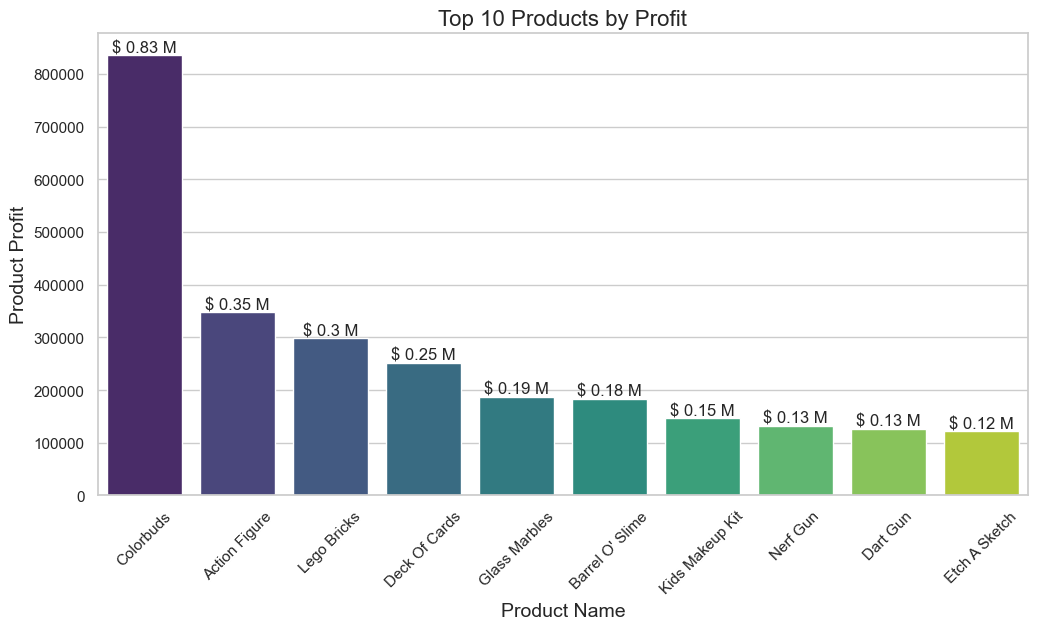

In [695]:
# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Product_Name', y='Product_profit', data=topProduct, palette="viridis")

# Add labels and title
plt.xlabel('Product Name', fontsize=14)
plt.ylabel('Product Profit', fontsize=14)
plt.title('Top 10 Products by Profit', fontsize=16)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Annotate bars with profit values
for i, row in topProduct.iterrows():
    plt.text(i, row.Product_profit, row.Total_Profit_M, ha='center', va='bottom')

# Show the plot
plt.show()

In [ ]:
# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Product_Name', y='Product_profit', data=topProduct, palette="viridis")

# Add labels and title
plt.xlabel('Product Name', fontsize=14)
plt.ylabel('Product Profit', fontsize=14)
plt.title('Top 10 Products by Profit', fontsize=16)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Annotate bars with profit values
for i, row in topProduct.iterrows():
    plt.text(i, row.Product_profit, row.Total_Profit_M, ha='center', va='bottom')

# Show the plot
plt.show()